In [1]:
'''
45325919, Anthony Cerqui
https://github.com/littletuna4/bism3206-assign
'''

'\n45325919, Anthony Cerqui\nhttps://github.com/littletuna4/bism3206-assign\n'

In [29]:
#Use this cell to import all the required libraries.
# %pip install gensim colorama nltk scikit-learn matplotlib seaborn pandas numpy scipy<1.13 ipykernel openpyxl vadersentiment


# Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from colorama import Fore, Style

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# SMOTE
from imblearn.over_sampling import SMOTE


# NLP  stuff
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.chunk import ne_chunk
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Linear Models
from sklearn.linear_model import LogisticRegression

#NNs
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Linear Dim Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# non-linear Dim Reduction (tsne, isomap, lle)
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding



# nltk downloads
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...


In [3]:
# #your work should only start with the following code
# df=pd.read_excel("Assignment_Data.xlsx")

# # Trim it up for dev purposes we only want say 1%
# df = df.sample(frac=0.01, random_state=1)
# # save to csv
# df.to_csv("Assignment_Data_1pc.csv", index=False)

df = pd.read_csv("Assignment_Data_1pc.csv")

#### <font color="red"> When you are preparing your assignment, you can use as many cells as you want. However, before submitting, please ensure that you consolidate all the necessary codes for each section into a single cell according to the template requirements. Failing to follow the template will lead to a loss of marks.

# Data exploration

_In this cell, in no more than 200 words, you can elaborate on the major understanding of data based on your data exploration._

The dataset relates to social media data, containing information about news authors, headlines, tweets, and various metrics about user engagement and demographic details. It has a total of 134,198 entries across 16 features, without duplicate entries, indicating good data cleanliness in terms of redundancy. Several features have a significant amount of missing data, particularly user_following and user_country, which could impact analysis related to user demographics and behavior.

The descriptive statistics reveal a highly skewed distribution in engagement metrics (post_replies, post_retweets, post_favourites, post_quotes), with most posts receiving zero engagement but a few outliers receiving extremely high interaction, suggesting viral behavior for a minority of posts. User metrics like user_followers, user_favourites, and user_tweets_count also display wide variances, indicating a diverse user base from minimally active to influential users.

Misinformation flagged in roughly half of the entries (mean=0.514), highlighting the dataset's utility for studying the spread and impact of misinformation across social platforms. The data includes a variety of unique authors, headlines, and tweets, which can be useful for textual analysis and pattern recognition in social media discussions. The significant presence of missing values, especially in demographic-related columns, suggests a need for careful handling and possibly imputation techniques for more robust analyses.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   news_author             1342 non-null   object 
 1   news_headline           1341 non-null   object 
 2   related_tweet           1342 non-null   object 
 3   post_replies            1342 non-null   float64
 4   post_retweets           1342 non-null   int64  
 5   post_favourites         1342 non-null   int64  
 6   post_quotes             1342 non-null   int64  
 7   user_followers          1342 non-null   float64
 8   user_following          451 non-null    float64
 9   user_friends            1342 non-null   float64
 10  user_mentions           1341 non-null   float64
 11  user_favourites         1342 non-null   float64
 12  user_tweets_count       1342 non-null   float64
 13  user_tweet_count_lists  1342 non-null   float64
 14  user_country            665 non-null    

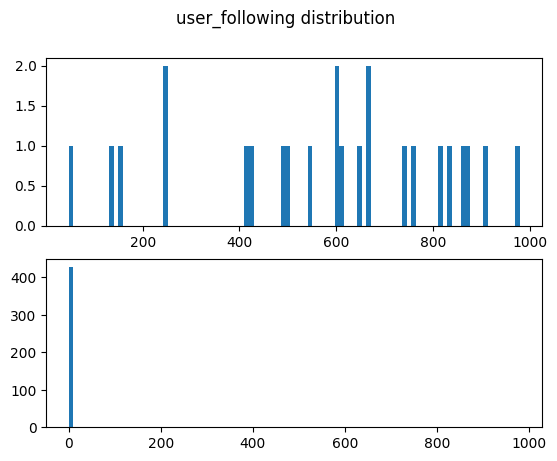

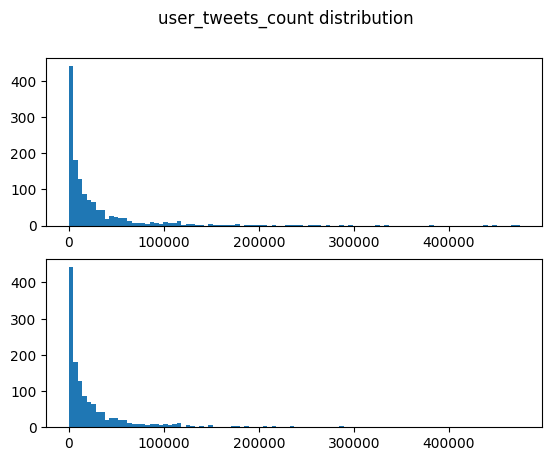

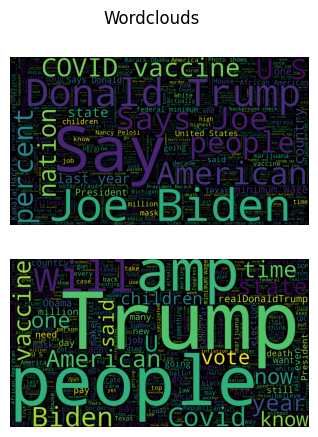

In [4]:
#Use this cell for data exploration.

def deco(a_string):
  return Style.BRIGHT+Fore.BLUE+a_string+Style.RESET_ALL


# here's some general first-pass stuff
print(
    deco("df.head()\n"),df.head(),
    deco("df.info()\n"),df.info(),
    deco("df.describe()\n"),df.describe(),
    deco("df.columns\n"),df.columns,
    deco("df.shape\n"),df.shape,
    deco("df.isnull().sum()\n"),df.isnull().sum(),
    deco("df.duplicated().sum()\n"),df.duplicated().sum(),
    deco("df.nunique()\n"),df.nunique(),
    sep="\n"
)
# what are the unique types of each object column?   
print(
    deco("df.apply(lambda x: x.apply(lambda y: type(y)).value_counts(dropna=False))\n"),df.apply(lambda x: x.apply(lambda y: 'nan' if pd.isnull(y) else str(type(y))).value_counts()),
    sep="\n"
)

# Here's some more specific details after asking myself some questions
# What are the 161 unique news_authors? 
print(
    deco("df['news_author'].unique()\n"),df['news_author'].unique(),
    sep="\n"
)
# only 161 unique authors, that's not too bad and they're all well formatted. also, no doubt, these will be a good indicator; some will be more prone to missinformation. I probably won't process them much if at all - I'll just use them as a feature.



# the countries about an even split of string and nans - lets see how the text ones are distributed (also, lets check the form of the misinformation column)
print(
    deco("df['user_country'].value_counts()\n"),df['user_country'].value_counts(),
    deco("df['misinformation'].value_counts()\n"),df['misinformation'].value_counts(), # roughly even split 1.0, and 0.0
    sep="\n"
)
# mostly "US", and some "AU" - not many au though - I'll probably just drop this column
# lets compare the ratio of ratio of misinformation to not misinformation in the US and AU and other
print(
    deco("df[df['user_country']=='US']['misinformation'].value_counts(normalize=True)\n"),df[df['user_country']=='US']['misinformation'].value_counts(normalize=True), 
    deco("df[df['user_country']=='AU']['misinformation'].value_counts(normalize=True)\n"),df[df['user_country']=='AU']['misinformation'].value_counts(normalize=True),
    deco("df[df['user_country'].isnull()]['misinformation'].value_counts(normalize=True)\n"),df[df['user_country'].isnull()]['misinformation'].value_counts(normalize=True),
    sep="\n"
)
# Straight up, this column is not looking useful by itself - it'll only be considered for Simpon's paradox purposes - but that seems a hell of a stretch

# let's compare the ratio of misinformation to not misinformation for the user_following column - if the nan's have a different ratio to the 0's then, we should definetely use something better than just replacing them with 0
print(
    Fore.GREEN+Style.BRIGHT+"userFollowing\n"+Style.RESET_ALL,
    deco("df[df['user_following'].isnull()]['misinformation'].value_counts(normalize=True)\n"),df[df['user_following'].isnull()]['misinformation'].value_counts(normalize=True),
    deco("df[df['user_following']==0]['misinformation'].value_counts(normalize=True)\n"),df[df['user_following']==0]['misinformation'].value_counts(normalize=True),
    # then for neither
    deco("df[(df['user_following'].isnull())or(df['user_following']==0)]['misinformation'].value_counts(normalize=True)\n"),df[(df['user_following'].isnull())|(df['user_following']==0)]['misinformation'].value_counts(normalize=True),
    sep="\n"  
)

# lets check the "user_following" col for distribution - lots of nans - lets see how the floats are distributed using a histogram of the frequency distribution of the non-nans and non-zeros
# fig, ax = plt.subplots() 
fig, axs = plt.subplots(2, 1)
fig.suptitle('user_following distribution')
axs[1].hist(df['user_following'].dropna(), bins=100)
axs[0].hist(df['user_following'].replace(0,np.nan).dropna(), bins=100)

# do the samefor the user_tweets_count column
fig, axs = plt.subplots(2, 1)
fig.suptitle('user_tweets_count distribution')
axs[1].hist(df['user_tweets_count'].dropna(), bins=100)
axs[0].hist(df['user_tweets_count'].replace(0,np.nan).dropna(), bins=100)


'''
these are the cols with relatively few nulls - let's see how many rows we'd lose if we dropped them (as a fraction of the whole data set)
news_headline -> drop
    related_tweet -> drop
    post_replies -> drop
    user_followers -> drop
    user_friends -> drop
    user_mentions -> drop
    user_favourites -> drop
    user_tweets_count -> drop
    user_tweet_count_lists -> drop
    misinformation -> drop 
'''
print(
    deco("df[['news_headline','related_tweet','post_replies','user_followers','user_friends','user_mentions','user_favourites','user_tweets_count','user_tweet_count_lists','misinformation']].dropna().shape[0]/df.shape[0]\n"),df[['news_headline','related_tweet','post_replies','user_followers','user_friends','user_mentions','user_favourites','user_tweets_count','user_tweet_count_lists','misinformation']].dropna().shape[0]/df.shape[0],
    sep="\n"
)
# .996 remains - thats fine to drop 'em

# lets review if the misinformation column is balance by getting unique counts of misinformation
df["misinformation"].value_counts() #looks about even :) won't have to resample

# finally, lets run a wordcloud on the news_headline and tweet columns - that'll give us a good idea of the most common words and maybe the topics
wc = WordCloud(width=1600, height=900, max_words=1000).generate(' '.join(df['news_headline'].dropna()))
wc2 = WordCloud(width=1600, height=900, max_words=1000).generate(' '.join(df['related_tweet'].dropna()))
fig, axs = plt.subplots(2,1)
fig.suptitle('Wordclouds')
axs[0].imshow(wc)
axs[0].axis('off')
axs[1].imshow(wc2)
axs[1].axis('off')
plt.show()


# Text preparation

In this cell, in no more than 150 words, you can elaborate on the the innovativeness and depth of your work on text preparation.

In [5]:

#Use this cell for text preparation.

# So it's easy to follow lets build the model df from scratch instead of ontop of the original df
mdf = pd.DataFrame()


'''
Null handling:
We don't really want to drop rows if it can be avoided, so we'll fill the null values with a placeholder where we can.
    Headlines -> drop
    Tweets -> drop
    post_replies -> drop
    user_followers -> drop
    user_friends -> drop
    user_mentions -> drop
    user_favourites -> drop
    user_tweets_count -> drop
    user_tweet_count_lists -> drop
    misinformation -> drop 
    User_following -> 0 (assuming they're not following anyone, far too many to drop)
    User_country -> "Other" (assuming they're not from the US or AU, far too many to drop)
'''
df_nulls_handled = df.copy()
# get a mask of the rows with nulls in the columns we want to drop
rows_to_drop = df[['news_headline','related_tweet','post_replies','user_followers','user_friends','user_mentions','user_favourites','user_tweets_count','user_tweet_count_lists','misinformation']].isnull().any(axis=1)
df_nulls_handled = df_nulls_handled[~rows_to_drop] # drop them
# fill the user following and user_country columns
df_nulls_handled['user_following'] = df_nulls_handled['user_following'].fillna(0)
df_nulls_handled['user_country'] = df_nulls_handled['user_country'].fillna("Other")

# put the nulls_handled "misinformation" column into the new dataframe
mdf['misinformation'] = df_nulls_handled['misinformation']


'''
Lowercasing:
We can remove the case sensitivity of the text by converting all the words to lowercase.
'''
# I will apply this to the "news_headline" and "related_tweet" columns and add the lowercase versions to the new dataframe
mdf['headline_lower'] = df_nulls_handled['news_headline'].apply(lambda x: x.lower())
mdf['tweet_lower'] = df_nulls_handled['related_tweet'].apply(lambda x: x.lower())

'''
Stopword removal
We can remove unimportant words to reduce the computation load and improve the potency of the training data
'''
mdf['headline_lower'] = mdf['headline_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))
mdf['tweet_lower'] = mdf['tweet_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))
'''
Punctuation and special character removal
Much like stopword removal, this technique is good for omitting unimportant data.
'''
mdf['headline_lower'] = mdf['headline_lower'].apply(lambda x: re.sub(r'[^\w\s]','',x))
mdf['tweet_lower'] = mdf['tweet_lower'].apply(lambda x: re.sub(r'[^\w\s]','',x))

'''
Tag Extraction
In twitter posts, we can extract tagged users by looking for words that start with a @ symbol, and tagged concepts by looking for words that start with a # symbol.
It's not as simple as just splitting the text by spaces, as the tags can be attached to words. so we'll split the text by spaces, filter for those with "@" or "#" in them at all, then split them by those symbols and remove the first element
# ADVANCED?
'''
# Regex to find mentions and hashtags respectively
extract_mentions = lambda text : re.findall(r'(?:(?<=\s)|(?<=^))@\w[\w.]*', text)
extract_hashtags = lambda text: re.findall(r'#\w+', text)
mdf['mentions'] = df_nulls_handled['related_tweet'].apply(extract_mentions)
mdf['hashtags'] = df_nulls_handled['related_tweet'].apply(extract_hashtags)
# then lets get counts
mdf['mentions_count'] = mdf['mentions'].apply(len)
mdf['hashtags_count'] = mdf['hashtags'].apply(len)


'''
stemming
Stemming is a technique used to reduce words to their root form.
we can use the nltk library to stem words in the text.
'''
stemmer = nltk.stem.PorterStemmer()
mdf['headline_stemmed'] = mdf['headline_lower'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
mdf['tweet_stemmed'] = mdf['tweet_lower'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


'''
lemmatization
lemmatization is another technique used to reduce words to their root form.
'''
lemmatizer = nltk.stem.WordNetLemmatizer()
mdf['headline_lemmatized'] = mdf['headline_lower'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
mdf['tweet_lemmatized'] = mdf['tweet_lower'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))



# finally lets take a look at the input dataframe
print(
    deco("mdf.head()\n"),mdf.head(),
    deco("mdf.info()\n"),mdf.info(),
    deco("mdf.describe()\n"),mdf.describe(),
    deco("mdf.columns\n"),mdf.columns,
    deco("mdf.shape\n"),mdf.shape,
    deco("mdf.isnull().sum()\n"),mdf.isnull().sum(),
    # deco("mdf.duplicated().sum()\n"),mdf.duplicated().sum(),
    # deco("mdf.nunique()\n"),mdf.nunique(),
    sep="\n"
)

<class 'pandas.core.frame.DataFrame'>
Index: 1339 entries, 0 to 1341
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   misinformation       1339 non-null   float64
 1   headline_lower       1339 non-null   object 
 2   tweet_lower          1339 non-null   object 
 3   mentions             1339 non-null   object 
 4   hashtags             1339 non-null   object 
 5   mentions_count       1339 non-null   int64  
 6   hashtags_count       1339 non-null   int64  
 7   headline_stemmed     1339 non-null   object 
 8   tweet_stemmed        1339 non-null   object 
 9   headline_lemmatized  1339 non-null   object 
 10  tweet_lemmatized     1339 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 125.5+ KB
mdf.head()

   misinformation                                     headline_lower  \
0             0.0                    says joe biden said racial slur   
1             0.0  early mor

# Feature engineering

In this cell, in no more than 150 words, you can elaborate on the the innovativeness of your work on feature generation.

##### Feature 1 generation

In [6]:
#Use this cell for text feature_1 generation.

'''
Vadar sentiment
Vadar sentiment is a simple-to-execute technique used to determine the sentiment of a text.
It understands the punctuation and capitalisation of the text, so we will use it on the the raw text.
'''
mdf['sentiment'] = df['related_tweet'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])


In [7]:
'''
Bag Of words
The bag of words model is a simple model that represents text data as a bag of words.
It ignores order and grammar, and only considers the frequency of words in the text - it also serves as
the input to TLF-IDF and Word2Vec models.
'''
# then we'll tokenize the text with punkt
mdf['tokens'] = ( mdf['headline_lower'] + " " + mdf['tweet_lower']).apply(word_tokenize)


'''We'll alos make a dictionary and corpus of the bag of words - this will be useful for the LDA model, we'll also prepare a tfidf model against the corpus'''
# we'll use the tokens to create a dictionary and a corpus
dictionary = corpora.Dictionary(mdf['tokens'])
corpus = [dictionary.doc2bow(text) for text in mdf['tokens']]
'''
TFIDF -
TFIDF is a measure of how important a word is in a document.
It is calculated by multiplying the term frequency of a word in a document by the
inverse document frequency of the word across all documents.
'''
tfidf = gensim.models.TfidfModel(corpus)
# and apply it to the corpus
mdf['tfidf'] = tfidf[corpus]


# dimensionality reduction/svd


In [8]:
'''
# lets tokenise and vectorise the tags.
# we'll use the tokens to create a dictionary and another corpus
'''
mentiondictionary = corpora.Dictionary(mdf['mentions'])
hashtagdictionary = corpora.Dictionary(mdf['hashtags'])
mentioncorpus = [mentiondictionary.doc2bow(text) for text in mdf['mentions']]
hashtagcorpus = [hashtagdictionary.doc2bow(text) for text in mdf['hashtags']]
'''
# we'll use the tokens to create a dictionary and another corpus
'''
mentiontfidf = gensim.models.TfidfModel(mentioncorpus)
hashtagtfidf = gensim.models.TfidfModel(hashtagcorpus)
# and apply it to the corpus
mdf['mentionstfidf'] = mentiontfidf[mentioncorpus]
mdf['hashtagstfidf'] = hashtagtfidf[hashtagcorpus]


'''
# lets take a look at the input dataframe
'''
mdf.head()

,misinformation,headline_lower,tweet_lower,mentions,hashtags,mentions_count,hashtags_count,headline_stemmed,tweet_stemmed,headline_lemmatized,tweet_lemmatized,sentiment,tokens,tfidf,mentionstfidf,hashtagstfidf
0,0.0,says joe biden said racial slur,ritapanahi someone called rock racial slur bac...,[@RitaPanahi],[],1,0,say joe biden said racial slur,ritapanahi someon call rock racial slur back 1...,say joe biden said racial slur,ritapanahi someone called rock racial slur bac...,0.4404,"[says, joe, biden, said, racial, slur, ritapan...","[(0, 0.29909448328488253), (1, 0.1357556090295...","[(0, 1.0)]",[]
1,0.0,early morning election results michigan wiscon...,josephfordcotto voter fraud texas like michiga...,[@JosephFordCotto],[],1,0,earli morn elect result michigan wisconsin sho...,josephfordcotto voter fraud texa like michigan...,early morning election result michigan wiscons...,josephfordcotto voter fraud texas like michiga...,0.4973,"[early, morning, election, results, michigan, ...","[(2, 0.06820017100213929), (16, 0.224990666159...","[(1, 1.0)]",[]
2,0.0,pfizer covid19 vaccine approved,mariebecquelin rolandspbx fda made announcemen...,"[@MarieBecquelin, @RolandSpbx]",[],2,0,pfizer covid19 vaccin approv,mariebecquelin rolandspbx fda made announc blo...,pfizer covid19 vaccine approved,mariebecquelin rolandspbx fda made announcemen...,0.4215,"[pfizer, covid19, vaccine, approved, mariebecq...","[(47, 0.1784842087316561), (48, 0.250970598009...","[(2, 0.7071067811865475), (3, 0.70710678118654...",[]
3,0.0,doctors get money somebody dies covid say im s...,thelastleg isitok trump told voters our doctor...,[@TheLastLeg],[#isitok],1,1,doctor get money somebodi die covid say im sor...,thelastleg isitok trump told voter our doctor ...,doctor get money somebody dy covid say im sorr...,thelastleg isitok trump told voter our doctor ...,0.0000,"[doctors, get, money, somebody, dies, covid, s...","[(14, 0.1382806274420189), (62, 0.164557043312...","[(4, 1.0)]","[(0, 1.0)]"
4,1.0,africans living china forced sleep outside col...,vanguardngrnews vanguardngr everything award a...,"[@vanguardngrnews, @vanguardngr]",[],2,0,african live china forc sleep outsid cold chin...,vanguardngrnew vanguardngr everyth award afric...,african living china forced sleep outside cold...,vanguardngrnews vanguardngr everything award a...,0.6562,"[africans, living, china, forced, sleep, outsi...","[(36, 0.11830471924577853), (80, 0.10335015669...","[(5, 0.7071067811865475), (6, 0.70710678118654...",[]


In [9]:
print(
    deco("mdf.isnull().sum()\n"),mdf.isnull().sum(),
    sep="\n"
)
# lets actually view the rows with nulls in them
print(mdf[mdf.isnull().any(axis=1)])


mdf.isnull().sum()

misinformation         0
headline_lower         0
tweet_lower            0
mentions               0
hashtags               0
mentions_count         0
hashtags_count         0
headline_stemmed       0
tweet_stemmed          0
headline_lemmatized    0
tweet_lemmatized       0
sentiment              0
tokens                 0
tfidf                  0
mentionstfidf          0
hashtagstfidf          0
dtype: int64
Empty DataFrame
Columns: [misinformation, headline_lower, tweet_lower, mentions, hashtags, mentions_count, hashtags_count, headline_stemmed, tweet_stemmed, headline_lemmatized, tweet_lemmatized, sentiment, tokens, tfidf, mentionstfidf, hashtagstfidf]
Index: []


In [10]:
# tfidf to vectors: for the 3 tfidf columns, we want to blow them out into their vectors
# tfidf values are lists of tuples of length 2 (the first is the key, the second it the value.), we want each key as a column (being careful not to double up for raw, mentions and hashtags)

# first convert each to a list of dicts. we rename the keys to avoid collisions
tfidf_df = pd.DataFrame()
tfidf_df['post'] = mdf['tfidf'].apply(lambda x: {str(k)+"_tfidf":v for k,v in dict(x).items() })
tfidf_df['mentions'] = mdf['mentionstfidf'].apply(lambda x: {str(k)+"_mentionstfidf":v for k,v in dict(x).items()})
tfidf_df['hashtags']= mdf['hashtagstfidf'].apply(lambda x: {str(k)+"_hashtagstfidf":v for k,v in dict(x).items()})

# then combine the dicts useing an apply and a fill na 
tfidf_df = tfidf_df.apply(lambda x: pd.Series({k:v for d in x for k,v in d.items()}), axis=1).fillna(0)

tfidf_df, tfidf_df.shape # a whole lot of columns so we won't add to the main df just yet


(      0_hashtagstfidf  0_mentionstfidf   0_tfidf  1000_mentionstfidf  \
 0                 0.0              1.0  0.299094                 0.0   
 1                 0.0              0.0  0.000000                 0.0   
 2                 0.0              0.0  0.000000                 0.0   
 3                 1.0              0.0  0.000000                 0.0   
 4                 0.0              0.0  0.000000                 0.0   
 ...               ...              ...       ...                 ...   
 1337              0.0              0.0  0.000000                 0.0   
 1338              0.0              0.0  0.000000                 0.0   
 1339              0.0              0.0  0.000000                 0.0   
 1340              0.0              0.0  0.000000                 0.0   
 1341              0.0              0.0  0.000000                 0.0   
 
       1000_tfidf  1001_mentionstfidf  1001_tfidf  1002_mentionstfidf  \
 0            0.0                 0.0         0.0

In [11]:
# apply some dimensionality reduction to the tfidf vectors
svd = TruncatedSVD(n_components=100)
svd.fit(tfidf_df)
svd_df = pd.DataFrame(svd.transform(tfidf_df))
svd_df.columns = [f"svd_{i}" for i in svd_df.columns]
svd_df # 100 columns, much more manageable


# 


,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,...,svd_90,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99
0,0.029034,0.098669,-0.087346,0.020272,-0.049645,0.025684,0.025313,-0.057086,-0.067616,-0.003235,...,0.042539,0.029729,-0.017134,0.053430,0.146213,0.006281,0.006067,0.100935,-0.065632,-0.074170
1,0.040913,0.094527,0.003978,-0.082405,-0.007109,-0.020884,0.011132,0.188184,-0.157672,-0.101971,...,-0.041449,-0.019731,0.009765,-0.035670,0.036559,0.009746,-0.034975,-0.062511,-0.045464,0.150611
2,0.013795,0.072585,0.017706,-0.117724,0.048477,-0.051732,0.029011,-0.101118,0.045767,-0.093613,...,0.009681,-0.034956,-0.008764,0.018294,0.053969,0.014353,-0.067896,0.000050,-0.019027,-0.078088
3,0.041987,0.134308,0.042898,-0.187441,0.053593,-0.082506,0.055575,-0.153918,0.049112,-0.137777,...,0.026665,-0.035507,-0.006862,0.041844,-0.009326,-0.031941,-0.008092,-0.009625,-0.015247,0.031293
4,0.019330,0.068903,0.002229,-0.037587,0.003809,-0.015978,0.001336,0.005680,0.006736,-0.002622,...,0.050766,0.153197,0.003113,-0.048462,-0.027436,-0.022493,-0.053323,-0.042073,-0.002665,0.027600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,0.306112,-0.019471,0.029905,-0.008565,-0.002471,-0.010668,-0.006765,-0.012992,0.016060,-0.015110,...,0.014084,0.022150,-0.002013,0.027752,-0.023899,0.145175,0.061132,0.024011,-0.027307,-0.079273
1335,0.013018,0.058733,0.006433,-0.078861,0.017731,-0.027762,0.040181,-0.044448,-0.001437,-0.025534,...,-0.021998,-0.022918,0.021599,0.008527,-0.014508,0.045190,0.035170,0.004268,0.007627,0.014714
1336,0.018027,0.054801,0.011477,-0.030555,0.013984,-0.009837,-0.015780,0.011564,-0.010513,-0.003947,...,-0.014832,0.004266,0.026911,0.014764,-0.019718,-0.003461,-0.029272,0.040848,-0.008757,-0.032339
1337,0.026132,0.137152,-0.091839,0.158506,0.305559,-0.005355,0.081251,-0.013028,0.021498,-0.059718,...,-0.080756,-0.021124,-0.133066,-0.018364,-0.014558,0.096436,0.031950,0.022100,-0.023843,0.011158


Feature 2 generation

In [12]:
'''
LDA (Latent Dirichlet Allocation) (its pretty much a standard dim reduction)
LDA is a technique used to extract topics from a text.
It is useful for understanding the underlying themes of a text.
The output is a list of topics, each with a list of words that represent the topic.
It can be applied to the bag of words model
In comparison to tfidf, LDA is a more advanced technique that can extract topics from a text.
'''
n_topics = 4

ldaModel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=10)
topics = ldaModel.print_topics()
for topic in topics:
    print(topic)


# now we want to get a column for each topic that we can use as features on each of the twitter posts
# we'll use the tfidf model to get the topic distribution
print([ldaModel.get_document_topics(text) for text in mdf['tfidf']])
topic_dist = [ [score for topic_index, score in line] for line in[ldaModel.get_document_topics(text) for text in mdf['tfidf']]]

# then we'll make a dataframe from the topic distribution
topicdf = pd.DataFrame(topic_dist, columns=[f"topic_{i}" for i in range(n_topics)])
topicdf # viewing hte topic distribution, it seems that the 





(0, '0.007*"says" + 0.006*"one" + 0.005*"world" + 0.005*"us" + 0.005*"vaccine" + 0.004*"would" + 0.004*"tax" + 0.004*"new" + 0.004*"income" + 0.003*"texas"')
(1, '0.007*"people" + 0.006*"says" + 0.005*"years" + 0.004*"overdose" + 0.004*"deaths" + 0.004*"covid" + 0.004*"trump" + 0.004*"masks" + 0.004*"black" + 0.004*"drug"')
(2, '0.010*"trump" + 0.008*"says" + 0.006*"biden" + 0.005*"years" + 0.004*"minimum" + 0.004*"us" + 0.004*"get" + 0.004*"president" + 0.004*"wage" + 0.004*"last"')
(3, '0.011*"biden" + 0.008*"joe" + 0.007*"says" + 0.007*"people" + 0.007*"vaccine" + 0.006*"trump" + 0.005*"covid19" + 0.005*"americans" + 0.004*"taxes" + 0.004*"covid"')
[[(0, 0.056427527), (1, 0.05559027), (2, 0.058045007), (3, 0.82993716)], [(0, 0.040705383), (1, 0.040432174), (2, 0.87842387), (3, 0.040438566)], [(0, 0.058171026), (1, 0.057603233), (2, 0.05517342), (3, 0.8290523)], [(0, 0.052733276), (1, 0.052731477), (2, 0.841519), (3, 0.05301631)], [(0, 0.878684), (1, 0.04037113), (2, 0.04031572), (3,

,topic_0,topic_1,topic_2,topic_3
0,0.056428,0.055590,0.058038,0.829944
1,0.040707,0.040431,0.878424,0.040438
2,0.058178,0.057604,0.055173,0.829044
3,0.052733,0.052730,0.841518,0.053018
4,0.878703,0.040371,0.040316,0.040610
...,...,...,...,...
1334,0.187777,0.050963,0.050599,0.710661
1335,0.038456,0.884867,0.038239,0.038439
1336,0.043478,0.136325,0.774334,0.045863
1337,0.041106,0.041709,0.040939,0.876246


In [13]:

'''
Word2Vec
Word2Vec is a technique used to represent words as vectors.
Suitable for preparing the data for neural networks models.
'''

word2vec = gensim.models.Word2Vec(mdf['tokens'], vector_size=100, window=1, min_count=1, workers=4)
# then we'll append the vectors to the dataframe
tokenvectorsdf = pd.DataFrame(
    mdf['tokens'].apply(
        lambda tokens: np.mean(
            [word2vec.wv[word] for word in tokens if word in word2vec.wv.key_to_index], axis=0
        ) if any(word in word2vec.wv.key_to_index for word in tokens) else np.zeros(word2vec.vector_size)
    ).tolist()
)
print(np.shape(tokenvectorsdf),np.shape( mdf))



(1339, 100) (1339, 16)


In [26]:
'''
POS Tagging
Considers Grammatical features of words
'''
# we'll use the tokens to get the pos tags
mdf['pos_tags'] = mdf['tokens'].apply(lambda x: [y[1] for y in nltk.pos_tag(x)])

'''
This can be used in the models as a feature
as it can be used to determine the grammatical structure of the text.
Perhaps useful as an indicator of low effort messages
'''
print(mdf['pos_tags'])


# we could use one hot encoding, but we'll lose some valuable information about the relationships between the tags
# So, we'll prepare this for an lstm model by padding the sequences and then converting the tags to their indices
# this will allow us to preserve the temporal relationships between the tags and hopefully allow us to 
# capture some of the grammatical structure of the text and thus some sense of credibility
pad = ''
# first we'll get the unique tags
unique_tags = set([tag for tags in mdf['pos_tags'] for tag in tags])
# add "" for padding
unique_tags.add(pad)
print(unique_tags)
# then we'll make a dict of the tags to their indices
tag2idx = {tag:i for i,tag in enumerate(unique_tags)}
# then we'll make a dict of the indices to their tags
idx2tag = {i:tag for i,tag in enumerate(unique_tags)}
# then we'll pad the sequences
maxlen = max([len(tags) for tags in mdf['pos_tags']])
mdf['pos_tags_array'] = mdf['pos_tags'].apply(lambda x: x + [pad]*(maxlen-len(x)))
# then we'll convert the tags to their indices
mdf['pos_tags_array'] = mdf['pos_tags_array'].apply(lambda x: [tag2idx[tag] for tag in x])
mdf['pos_tags_array'] # now we have a list of indices for each row, we can use this as a feature in a model - i'm thinking lstm

0       [VBZ, NN, NN, VBD, JJ, NN, NN, NN, VBD, NN, NN...
1       [JJ, NN, NN, NNS, VBD, JJ, NN, NN, NN, NN, NN,...
2       [NN, JJ, NN, VBD, JJ, NN, NN, VBD, NN, NN, NN,...
3       [NNS, VBP, NN, NN, VBZ, NNS, VBP, JJ, NN, CC, ...
4       [NNS, VBG, NN, VBD, JJ, IN, JJ, JJ, NNS, VBP, ...
                              ...                        
1337    [NN, VBZ, RBS, JJ, NN, NN, NN, JJ, NN, NNS, VB...
1338    [VBZ, NN, NN, VBD, NNS, VBP, JJ, NN, NNP, NN, ...
1339    [JJS, NN, NN, NN, VBD, CD, NNS, RB, VBD, JJ, C...
1340    [JJ, NNS, VBP, JJ, NN, NN, JJ, NN, NN, NN, NN,...
1341    [JJ, JJS, NN, JJ, NN, VBD, NNS, JJ, NN, NN, NN...
Name: pos_tags, Length: 1339, dtype: object
{'', 'JJS', 'RBR', 'UH', 'NN', 'PRP', 'MD', 'POS', 'CD', 'FW', 'DT', 'RP', 'PDT', 'TO', 'VBD', 'VBZ', 'RBS', 'NNPS', 'NNP', '$', 'CC', 'NNS', 'VBG', 'VB', 'VBP', 'WP', 'EX', 'JJR', 'RB', 'WDT', 'WP$', 'IN', 'VBN', 'WRB', 'JJ', 'PRP$'}


0       [15, 4, 4, 14, 34, 4, 4, 4, 14, 4, 4, 4, 28, 8...
1       [34, 4, 4, 21, 14, 34, 4, 4, 4, 4, 4, 4, 4, 31...
2       [4, 34, 4, 14, 34, 4, 4, 14, 4, 4, 4, 4, 32, 3...
3       [21, 24, 4, 4, 15, 21, 24, 34, 4, 20, 24, 4, 1...
4       [21, 22, 4, 14, 34, 31, 34, 34, 21, 24, 22, 4,...
                              ...                        
1337    [4, 15, 16, 34, 4, 4, 4, 34, 4, 21, 24, 34, 21...
1338    [15, 4, 4, 14, 21, 24, 34, 4, 18, 4, 4, 34, 4,...
1339    [1, 4, 4, 4, 14, 8, 21, 28, 14, 34, 8, 4, 4, 8...
1340    [34, 21, 24, 34, 4, 4, 34, 4, 4, 4, 4, 21, 4, ...
1341    [34, 1, 4, 34, 4, 14, 21, 34, 4, 4, 4, 1, 4, 4...
Name: pos_tags, Length: 1339, dtype: object

In [28]:
'''
Named Entity Recognition
Identifies named entities in text
'''

# we have the pos tags already, so we can use them to get the named entities
mdf['named_entities']  = mdf['pos_tags'].apply(lambda x: [y[0] for y in ne_chunk(x)])

# finally we'll one hot encode the named entities, might be useful to have the named entities as a feature



NameError: name 'ne_chunk' is not defined

.
.
.

##### Feature N generation

In [16]:
#Use this cell for text feature_N generation.

# Model Development
#### <font color="red">You must remove this section from your notebook before submission
<font color="black">This section is for you to work and develop any models you choose. <br>When you have found the best performing model, you should move it to the **Model building & evaluation** section below.

In [25]:
#Use this cell for developing or evaluating model_1.

'''
Descision Tree/Random forest

'''


misinformation
1.0    681
0.0    658
Name: count, dtype: int64

In [18]:
'''
NNs 1: Multiplayer perceptron applied to the token vectors
'''
# run it on the token vectors to start
X = tokenvectorsdf
y = mdf['misinformation']


# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# create the model
clf = MLPClassifier(random_state=1, max_iter=600).fit(X_train, y_train)
# evaluate the model
print(clf.score(X_test, y_test))


0.7601809954751131


c:\ProgramData\miniconda3\envs\bism\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
'''
NNs 2: LSTM on token vectors - not expecting this to perform well - no temporal structure in the token vectors
'''
# LSTM
X = np.array(tokenvectorsdf)
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshaping for LSTM input

y = mdf['misinformation'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64)
_, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy}")

C:\Users\seems\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5138 - loss: 0.6930
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5271 - loss: 0.6923 
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5379 - loss: 0.6924 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4842 - loss: 0.6930  
LSTM Model Accuracy: 0.49321267008781433


In [20]:
'''
NN's 3: lstm with pos tags included - this might detect some sort of translation or low effort or spammy posts
translation/native language might have some impact on the credibility of the post (although there might be an ethical consideration here)

The model will be trained on the pos tags column (which is a list of indices) only
'''
X = np.array(mdf['pos_tags_array'].tolist())
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM input
y = mdf['misinformation'].values





X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = Sequential()
model.add(LSTM(1000, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64)
_, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy}")

# lets get (and plot) a confusion matrix
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm)
# label extensively
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
# and tn, fp, fn, tp, accuracy, precision, recall, f1
tn, fp, fn, tp = cm.ravel()
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
# as text on plot 
plt.text(0,0,f"tn: {tn}", color='white', ha='center', va='center', backgroundcolor='black')
plt.text(1,0,f"fp: {fp}", color='white', ha='center', va='center', backgroundcolor='black')
plt.text(0,1,f"fn: {fn}", color='white', ha='center', va='center', backgroundcolor='black')
plt.text(1,1,f"tp: {tp}", color='white', ha='center', va='center', backgroundcolor='black')
plt.text(2,0,f"accuracy: {accuracy}", color='white', ha='center', va='center', backgroundcolor='black')
plt.text(2,1,f"precision: {precision}", color='white', ha='center', va='center', backgroundcolor='black')
plt.text(2,2,f"recall: {recall}", color='white', ha='center', va='center', backgroundcolor='black')
plt.text(2,3,f"f1: {f1}", color='white', ha='center', va='center', backgroundcolor='black')
plt.show()




ValueError: Found array with dim 3. SMOTE expected <= 2.

In [ ]:
'''
Logistic regresion
'''

In [ ]:
'''Composite Models'''

'''Composite one:'''


'Composite Models'

.
.
.

In [ ]:
#Use this cell for developing or evaluating model_N.

# here we'll create a confusion matrix for the each model


# Model building & evaluation
Once you have found the most optimal model, you should only show the model building and evaluation here!

In this cell, in no more than 300 words, you can elaborate on development and performance of your best model.

In [ ]:
#Use this cell for the best models building & evaluation.

# Kfold cross validation